In [1]:
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from glob import glob
from copy import deepcopy
from tabulate import tabulate

import sys
sys.path.append('../../Data/auxiliary/')
from img_path import img_files

In [2]:
def replace_special_char(string):
    changes = [('á', 'a'), ('à', 'a'), ('â', 'a'), ('ã', 'a'),
               ('é', 'e'), ('ê', 'e'), ('í', 'i'), ('ó', 'o'),
               ('ô', 'o'), ('õ', 'o'), ('ú', 'u'), ('ç', 'c')]
    
    for change in changes: string = string.replace(change[0], change[1])
    return string

In [3]:
club_list = list()
for file in sorted(glob('../../Data/results/processed/Serie_A_*_games.json')):
    with open(file, 'rb') as f: data = json.load(f)
    for game in data:
        home_club = data[game]['Home']
        away_club = data[game]['Away']
        if home_club not in club_list: club_list.append(home_club)
        if away_club not in club_list: club_list.append(away_club)

club_list = sorted(club_list, key=lambda x : (x[-2:], x[:-4]))

clubs_map = dict()
for club1 in club_list:
    clubs_map[club1] = dict()
    for club2 in club_list:
        clubs_map[club1][club2] = set()

for file_index, file in enumerate(sorted(glob('../../Data/results/processed/Serie_A_*_squads.json'))):
    year = int(file[-16:-12])
    if year == 2024: continue

    info_file = file.replace('squads', 'games')
    with open(file, 'rb') as f: data = json.load(f)
    with open(info_file, 'rb') as f: info = json.load(f)
    for game in data:
        home_club = info[game]['Home']
        away_club = info[game]['Away']
        for sub_game in data[game]:
            if home_club in clubs_map:
                home_squad = set(data[game][sub_game]['Home']['Squad'])
                clubs_map[home_club][home_club] = clubs_map[home_club][home_club].union(home_squad)
            
            if away_club in clubs_map:
                away_squad = set(data[game][sub_game]['Away']['Squad'])
                clubs_map[away_club][away_club] = clubs_map[away_club][away_club].union(away_squad)

for club1 in clubs_map:
    for club2 in clubs_map:
        if club1 == club2: continue
        commom_players = clubs_map[club1][club1].intersection(clubs_map[club2][club2])
        clubs_map[club1][club2] = len(commom_players)

for club in clubs_map:
    clubs_map[club][club] = len(clubs_map[club][club])

clubs_inx = dict()
for i, club in enumerate(club_list): clubs_inx[club] = i
inx_clubs = {value: key for key, value in clubs_inx.items()}

In [4]:
def create_graph(clubs_map, min_transfers=1):
    table = np.zeros((len(clubs_map), len(clubs_map)), dtype=int)
    for club1 in clubs_map:
        i = clubs_inx[club1]
        for club2 in clubs_map:
            j = clubs_inx[club2]
            table[i, j] = clubs_map[club1][club2]

    G = nx.Graph()
    for club in clubs_inx:
        i = clubs_inx[club]
        G.add_node(i, color='steelblue', weight=table[i][i])

    for club1 in clubs_inx:
        i = clubs_inx[club1]
        for club2 in clubs_inx:
            if club1 == club2: continue
            j = clubs_inx[club2]
            transfers = table[i][j]
            if transfers >= min_transfers: G.add_edge(i, j, color='lightskyblue', width=transfers, weight=transfers)

    return G

In [5]:
def plot_graph(G, save_fig=False):
    fig, ax = plt.subplots(figsize = (50, 50))
    pos = nx.circular_layout(G)
    nx.draw_networkx_edge_labels(G,
                                 pos,
                                 edge_labels=nx.get_edge_attributes(G, 'relation'),
                                 label_pos=1.5,
                                 font_size=9,
                                 font_color='red',
                                 font_family='sans-serif',
                                 font_weight='normal',
                                 alpha=1.0,
                                 bbox=None,
                                 ax=ax,
                                 rotate=True)

    nx.draw_networkx(G,
                     pos=pos,
                     ax=ax,
                     node_color=[nx.get_node_attributes(G, 'color')[g] for g in G.nodes()],
                     edge_color=[nx.get_edge_attributes(G, 'color')[g] for g in G.edges()],
                     node_size=[nx.get_node_attributes(G, 'weight')[g] * 10 for g in G.nodes()],
                     width=[nx.get_edge_attributes(G, 'width')[g] * 0.5 for g in G.edges()])

    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform
    weights = nx.get_node_attributes(G, 'weight')
    
    w_max = 0
    w_min = 1000
    for club in weights:
        if weights[club] > w_max: w_max = weights[club]
        if weights[club] < w_min: w_min = weights[club]

    dif = w_max - w_min
    labels = {}
    for g in G.nodes(): labels[g] = g
    nx.draw_networkx_labels(G,
                            pos=pos,
                            labels=labels,
                            ax=ax,
                            font_color='steelblue')

    for g in G.nodes():
        node = replace_special_char(inx_clubs[g]).replace(' ', '')
        img = mpimg.imread('../../' + img_files[node])
        weight = nx.get_node_attributes(G, 'weight')[g]
        imsize = (weight - w_min) / dif * 0.04 + 0.02
        (x, y) = pos[g]
        xx, yy = trans((x, y))
        xa, ya = trans2((xx, yy))
        a = plt.axes([xa - imsize / 2, ya - imsize / 2, imsize, imsize])
        a.imshow(img)
        a.set_aspect('equal')
        a.axis('off')

    if save_fig: plt.savefig(f'../figures/clubs_connectivity_{year}.png')

In [6]:
def calculate_communities(G):
    communities = nx.community.greedy_modularity_communities(G, weight='weight')
    n_communities = len(communities)
    print(f'We found a total of {n_communities} community(ies) in {year}')
    if n_communities > 1:
        for community_index, community in enumerate(communities):
            print(f'{community_index + 1}° community:')
            for club in community: print(f'  {club_list[club]}')
            print()


In [7]:
max_transfers = 0
for club1 in clubs_map:
    for club2 in clubs_map[club1]:
        if club1 == club2: continue
        tranfers = clubs_map[club1][club2]
        if tranfers > max_transfers:
            max_transfers = tranfers

In [8]:
stats = list()
mask = ['Min. transfer on edge', 'Isolated nodes', 'Communities', 'Connected components', 'Diameter']
stats.append(mask)
for tranfers in range(1, max_transfers + 1):
    G = create_graph(clubs_map, min_transfers=tranfers)
    n_isolates = nx.number_of_isolates(G)
    n_communities = len(nx.community.greedy_modularity_communities(G, weight='weight'))
    n_cc = nx.number_connected_components(G)
    if n_cc == 1: diameter = nx.diameter(G)
    else: diameter = np.inf
    stats.append([tranfers, n_isolates, n_communities, n_cc, diameter])

print(tabulate(stats))

---------------------  --------------  -----------  --------------------  --------
Min. transfer on edge  Isolated nodes  Communities  Connected components  Diameter
1                      0               3            1                     2
2                      0               3            1                     2
3                      0               3            1                     3
4                      1               4            2                     inf
5                      2               5            3                     inf
6                      5               8            6                     inf
7                      6               10           7                     inf
8                      6               9            7                     inf
9                      8               11           9                     inf
10                     10              14           11                    inf
11                     15              18           16      

In [9]:
def plot_graph(G, comunidades, save_fig=False, year=2024):
    fig, ax = plt.subplots(figsize=(50, 50))
    
    n_comunidades = len(comunidades)
    pos_comunidades = nx.circular_layout(range(n_comunidades), scale=5.0)
    
    posicoes = {}
    for i, comunidade in enumerate(comunidades):
        center = pos_comunidades[i]
        pos_comunidade = nx.circular_layout(comunidade, scale=3.0)
        
        for node in comunidade:
            posicoes[node] = pos_comunidade[node] + center

    nx.draw_networkx_edge_labels(G,
                                 posicoes,
                                 edge_labels=nx.get_edge_attributes(G, 'relation'),
                                 label_pos=1.5,
                                 font_size=9,
                                 font_color='red',
                                 font_family='sans-serif',
                                 font_weight='normal',
                                 alpha=1.0,
                                 bbox=None,
                                 ax=ax,
                                 rotate=True)

    nx.draw_networkx(G,
                     pos=posicoes,
                     ax=ax,
                     node_color=[nx.get_node_attributes(G, 'color').get(g, 'skyblue') for g in G.nodes()],
                     edge_color=[nx.get_edge_attributes(G, 'color').get(g, 'black') for g in G.edges()],
                     node_size=[nx.get_node_attributes(G, 'weight').get(g, 1) * 10 for g in G.nodes()],
                     width=[nx.get_edge_attributes(G, 'width').get(g, 1) * 0.5 for g in G.edges()])

    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform
    weights = nx.get_node_attributes(G, 'weight')
    
    w_max = max(weights.values(), default=1)
    w_min = min(weights.values(), default=1)

    dif = w_max - w_min
    labels = {g: g for g in G.nodes()}
    nx.draw_networkx_labels(G,
                            pos=posicoes,
                            labels=labels,
                            ax=ax,
                            font_color='steelblue')

    for g in G.nodes():
        node = replace_special_char(inx_clubs[g]).replace(' ', '')
        img = mpimg.imread('../../' + img_files[node])
        weight = nx.get_node_attributes(G, 'weight').get(g, 1)
        imsize = (weight - w_min) / dif * 0.03 + 0.02 if dif else 0.02
        (x, y) = posicoes[g]
        xx, yy = trans((x, y))
        xa, ya = trans2((xx, yy))
        a = plt.axes([xa - imsize / 2, ya - imsize / 2, imsize, imsize])
        a.imshow(img)
        a.set_aspect('equal')
        a.axis('off')

    if save_fig:
        plt.savefig(f'../figures/clubs_connectivity_{year}.png')


In [10]:
G = create_graph(clubs_map, min_transfers=1)

In [11]:
communities = nx.community.greedy_modularity_communities(G, weight='weight')

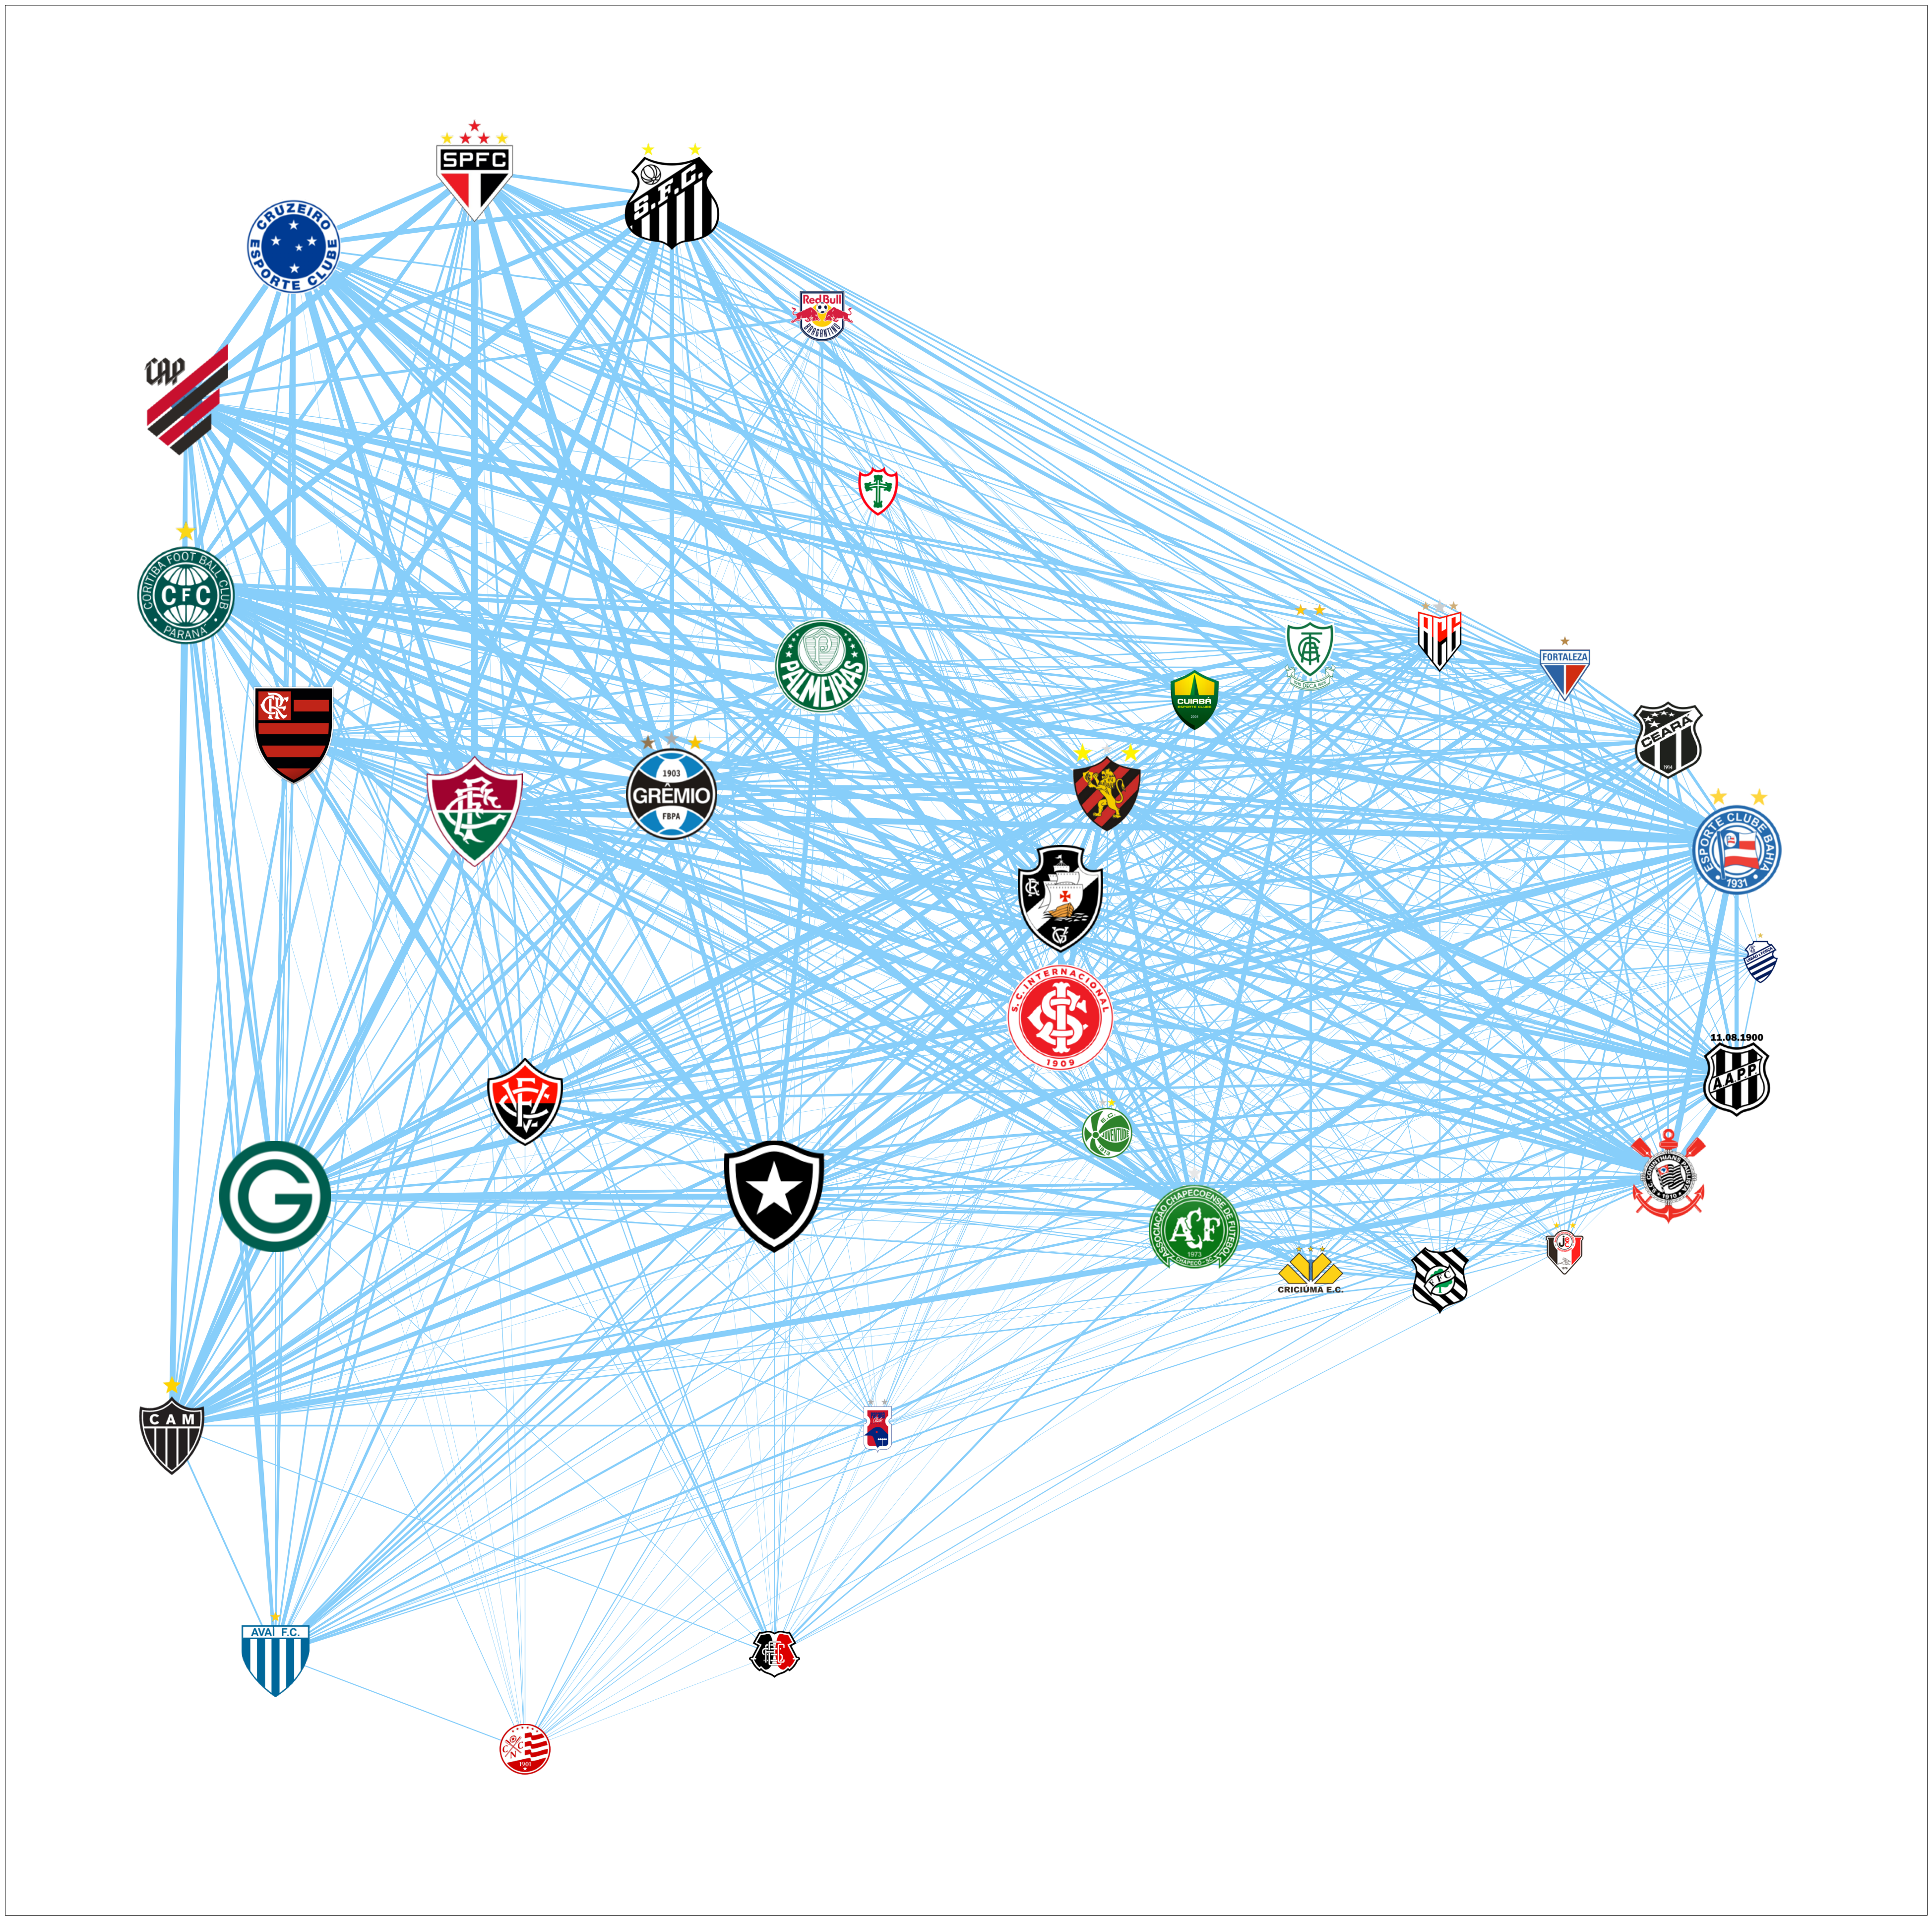

In [12]:
plot_graph(G, communities, save_fig=False)

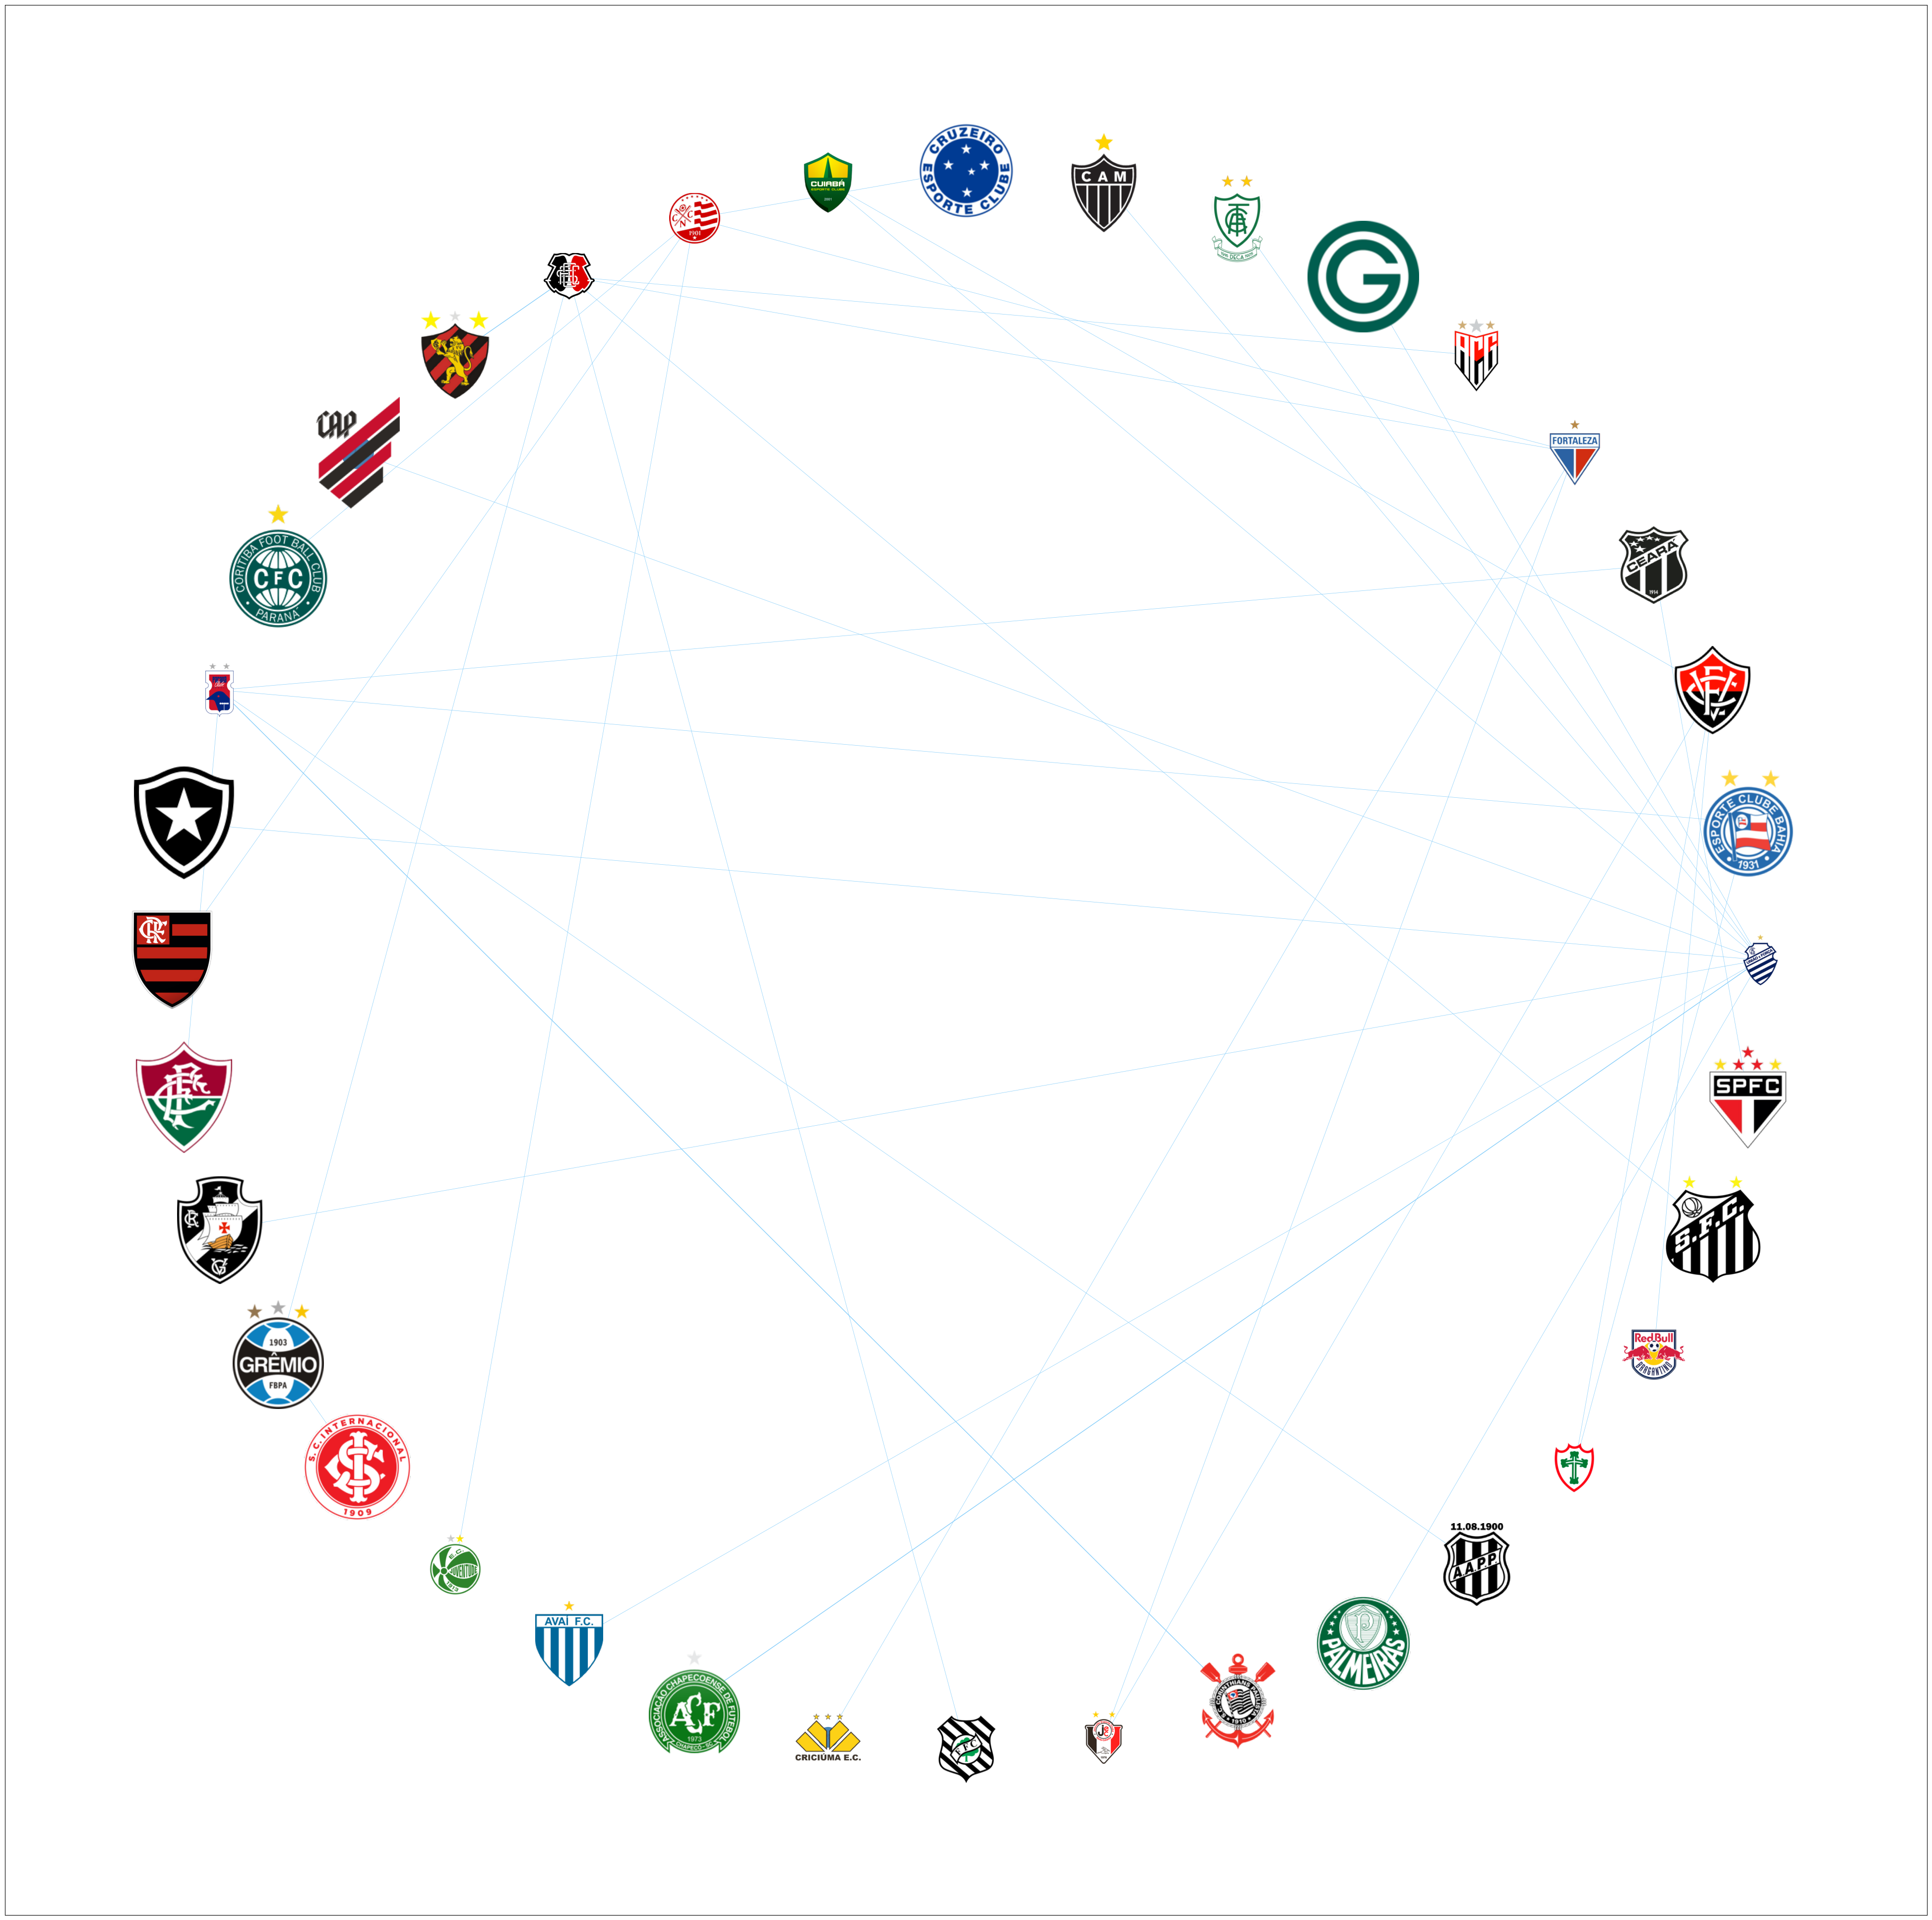

In [13]:
com = set()
for c in communities: com = com.union(c)
com = [frozenset(com)]

G_mst = nx.minimum_spanning_tree(G)
plot_graph(G_mst, com, save_fig=False)

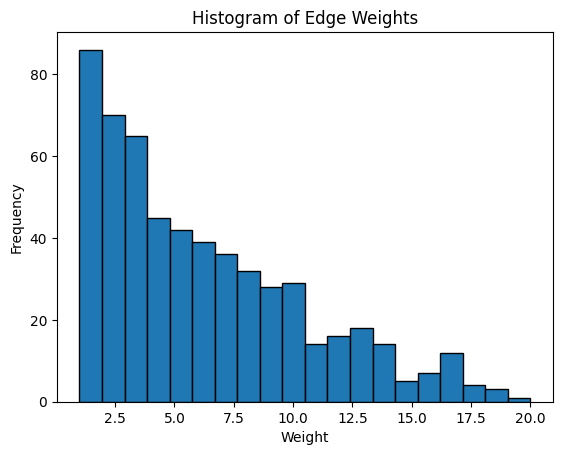

In [14]:
weights = [d['weight'] for (u, v, d) in G.edges(data=True)]
plt.hist(weights, bins=20, edgecolor='black')
plt.title('Histogram of Edge Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

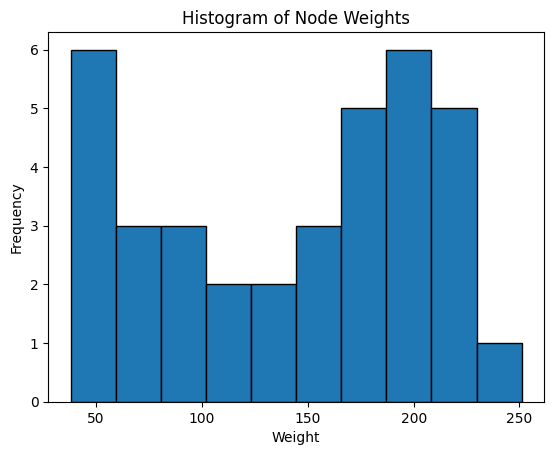

In [15]:
weights = [d['weight'] for (u, d) in G.nodes(data=True)]
plt.hist(weights, bins=10, edgecolor='black')
plt.title('Histogram of Node Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()